- [x]  Train Accuracy & Test Accuracy vs Epochs  
- [x]  Saturated Train Accuracy vs. Num_clients  
- [x]  Saturated Testing Accuracy vs. Num_Clients  
- [x]  Training accuracy vs Each client bar graph  
- [x]  Testing accuracy vs Each client bar graph  
- [x]  Generalising for multiple users  
- [x]  Accuracy per user  
- [x]  Different datasets  
- [x]  All of these for CNN model  
- [x]  How many parameters are being passed  
- [x]  Max batch size for each client  
- [x]  Calculate network overhead and computation per user  
- [x]  Transfer learning  
- [ ]  Trying on pregnancy data and breast cancer dataset

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
from math import prod
import random
import numpy as np

In [2]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper-parameters
input_size = 784
hidden_size1 = 500
hidden_size2 = 200
num_classes = 10
num_epochs = 5
learning_rate = 0.01
max_batch_size = 50
transfer_learning = False
pretrained_model_path = "./models/model1/"

In [4]:
num_clients = 10

In [5]:
# MNIST dataset

# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz ../../data

train_dataset = torchvision.datasets.MNIST(root='../../data',
                                           train=True,
                                           transform=transforms.ToTensor()
                                        #    download=True)
                                            )

test_dataset = torchvision.datasets.MNIST(root='../../data',
                                          train=False,
                                          transform=transforms.ToTensor())


train_batch_size = len(train_dataset)//num_clients
train_split = [train_batch_size]*(num_clients-1)
train_split.append(len(train_dataset)-train_batch_size*(num_clients-1))

test_batch_size = len(test_dataset)//num_clients
test_split = [test_batch_size]*(num_clients-1)
test_split.append(len(test_dataset)-test_batch_size*(num_clients-1))

train_datasets = list(torch.utils.data.random_split(train_dataset, train_split))
test_datasets = list(torch.utils.data.random_split(test_dataset, test_split))

# Data loaders
train_loaders = []
for train_dataset in train_datasets:
    train_loaders.append(torch.utils.data.DataLoader(dataset=train_dataset,
                                                batch_size=train_batch_size,
                                                shuffle=True))

test_loaders = []
for test_dataset in test_datasets:
    test_loaders.append(torch.utils.data.DataLoader(dataset=test_dataset,
                                                batch_size=test_batch_size,
                                                shuffle=True))

In [6]:
examples = iter(test_loaders[0])
example_data, example_targets = examples.next()
print(example_data.shape, example_targets.shape)

torch.Size([1000, 1, 28, 28]) torch.Size([1000])


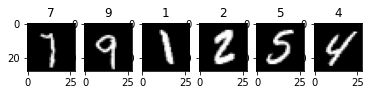

In [7]:
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.title(example_targets[i].item())
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
startModels = []
if transfer_learning == True:
    for i in range(num_clients):
        startModels.append(torch.load(pretrained_model_path + "/starting_model").to(device))

else:
    class ClientStartNN(nn.Module):
        def __init__(self, input_size, hidden_size1):
            super(ClientStartNN, self).__init__()
            self.l1 = nn.Linear(input_size, hidden_size1)
            self.relu = nn.ReLU()

        def forward(self, x):
            out = self.l1(x)
            out = self.relu(out)
            return out

    for i in range(num_clients):
        startModels.append(ClientStartNN(input_size, hidden_size1).to(device))

In [9]:
if transfer_learning == True:
    serverModel = torch.load(pretrained_model_path + "/middle_model").to(device)

else:
    class ServerNN(nn.Module):
        def __init__(self, hidden_size1, hidden_size2):
            super(ServerNN, self).__init__()
            self.l2 = nn.Linear(hidden_size1, hidden_size2)
            self.relu = nn.ReLU()
        
        def forward(self, x):
            out = self.l2(x)
            out = self.relu(out)
            return out

    serverModel = ServerNN(hidden_size1, hidden_size2).to(device)

In [10]:
# for parameter in serverModel.parameters():
#     print(parameter)

# print(serverModel.items())

In [11]:
endModels = []

if transfer_learning == True:
    for i in range(num_clients):
        endModels.append(torch.load(pretrained_model_path + "/ending_model").to(device))

else:
    class ClientEndNN(nn.Module):
        def __init__(self, hidden_size2, num_classes):
            super(ClientEndNN, self).__init__()
            self.input_size = input_size
            self.l1 = nn.Linear(hidden_size2, num_classes)
        
        def forward(self, x):
            out = self.l1(x)
            return out


    for i in range(num_clients):
        endModels.append(ClientEndNN(hidden_size2, num_classes).to(device))

In [12]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()

startOptimizers = []
for i in range(num_clients):
    startOptimizers.append(torch.optim.Adam(startModels[i].parameters(), lr=learning_rate))


serverOptimizer = torch.optim.Adam(serverModel.parameters(), lr=learning_rate)


endOptimizers = []
for i in range(num_clients):
    endOptimizers.append(torch.optim.Adam(endModels[i].parameters(), lr=learning_rate))

In [13]:
def mergeGrad(params):
    # params = [params_client1,
    #           params_client2,
    #           params_client3,
    #           ...
    #          ]
    for col in zip(*params):
        avg = 0
        for param in col:
            avg += param.grad
        avg /= num_clients
        for param in col:
            param.grad = avg.clone()

In [14]:
# training loop
total_train_acc = []
total_test_acc = []

"""
bandwidth_cost is a 3D numpy array with depth 4.
Depth is 4 because it stores bandwidth cost for:
activations from client to server at index 0,
activations from server to client at index 1,
gradients from client to server at index 2,
gradients from server to client at index 3.
"""
bandwidth_cost = np.zeros([num_clients, num_epochs, 4])

# To get bandwidth cost for sending activations 
# from server to client 50 in epoch 10, execute bandwidth_cost[50][10][1].

for epoch in range(num_epochs):
    grads = []
    losses = []
    n_correct = 0
    test_n_correct = 0
    n_samples = []
    n_samples = 0
    test_n_samples = 0
    for client in range(num_clients):
        images, labels = iter(train_loaders[client]).next()
        images = images.reshape(-1, 784).to(device)
        labels = labels.to(device)


        if max_batch_size < labels.shape[0]:
            random_indices = [random.randint(0, labels.shape[0]) for i in range(max_batch_size)]
            images = images[random_indices]
            labels = labels[random_indices]

        ## Forward
        # Forward through starting layers (with client 1)
        activations1 = startModels[client](images)
        remote_activations1 = activations1.detach().requires_grad_(True)      



        #### Pass remote_activations1 to server here
        
        ############################################



        # Storing the bandwidth cost for activations of client sending th server
        bandwidth_cost[client][epoch][0] = prod(remote_activations1.shape)

        # Forward through middle layers (with server) 
        activations2 = serverModel(remote_activations1)
        remote_activations2 = activations2.detach().requires_grad_(True)



        #### Pass remote_activations2 to corresponding client here

        ##########################################################



        # Storing the bandwidth cost for activations of server sending to client
        bandwidth_cost[client][epoch][1] = prod(remote_activations2.shape)

        # Forward through ending layers (with client 1)
        outputs = endModels[client](remote_activations2)


        # loss
        loss = criterion(outputs, labels)
        losses.append(loss.item())


        # Calculating Train Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            n_correct += (predicted == labels).sum().item()
            n_samples += labels.size(0)
        
        # Calculating Test Accuracy
        # This section drastically decreases training speed due to added forward prop in each iteration
        with torch.no_grad():
            test_images, test_labels = iter(test_loaders[client]).next()
            test_images = test_images.reshape(-1, 784).to(device)
            test_labels = test_labels.to(device)

            ## Forward
            # Forward through starting layers (with client 1)
            test_activations1 = startModels[client](test_images)
            test_remote_activations1 = test_activations1.detach().requires_grad_(True) 

            # Forward through middle layers (with server) 
            test_activations2 = serverModel(test_remote_activations1)
            test_remote_activations2 = test_activations2.detach().requires_grad_(True)

            # Forward through ending layers (with client 1)
            test_outputs = endModels[client](test_remote_activations2)

            # value, index
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_n_correct += (test_predicted == test_labels).sum().item()
            test_n_samples += test_labels.size(0)


        # Zeroing out all gradients
        startOptimizers[client].zero_grad()
        serverOptimizer.zero_grad()
        endOptimizers[client].zero_grad()

        # Back-propagation on ending model at client side
        loss.backward()



        #### Pass remote_activations2.grad to the server here

        #####################################################
        

        
        # Storing bandwidth cost for client sending gradients to server
        bandwidth_cost[client][epoch][2] = prod(remote_activations2.grad.shape)

        # Backpropagation on server without updating weights
        activations2.backward(remote_activations2.grad)



        #### Pass remote_activations1.grad to the corresponding clients here

        ####################################################################


        # Storing bandwidth cost for server sending gradients to client
        bandwidth_cost[client][epoch][3] = prod(remote_activations1.grad.shape)

        # Backpropatation of starting model at client
        activations1.backward(remote_activations1.grad)

        # Updating weights of starting model at client
        startOptimizers[client].step()

        # Storing gradients at the server
        grads.append(serverModel.parameters())

        # Updating weights of ending model at client
        endOptimizers[client].step()

    # Taking average of gradients at the server
    mergeGrad(grads)

    # Updating weights based on gradients at the server
    serverOptimizer.step()

    total_train_acc.append(100.0 * n_correct / n_samples)
    total_test_acc.append(100.0 * test_n_correct / test_n_samples)
    print(f'Epoch [{epoch+1}/{num_epochs}]: Avg Loss: {sum(losses)/num_clients:.4f}, Total Train Accuracy: {total_train_acc[-1]:.4f}, Total Test Accuracy: {total_test_acc[-1]:.4f}')

Epoch [1/5]: Avg Loss: 2.3060, Total Train Accuracy: 9.0000, Total Test Accuracy: 9.8700
Epoch [2/5]: Avg Loss: 2.2106, Total Train Accuracy: 26.4000, Total Test Accuracy: 23.4800
Epoch [3/5]: Avg Loss: 2.1101, Total Train Accuracy: 28.0000, Total Test Accuracy: 26.8800
Epoch [4/5]: Avg Loss: 1.8722, Total Train Accuracy: 41.0000, Total Test Accuracy: 38.4800
Epoch [5/5]: Avg Loss: 1.7125, Total Train Accuracy: 47.4000, Total Test Accuracy: 45.5400


In [15]:
print(bandwidth_cost[0][0][0],
        bandwidth_cost[0][0][1],
        bandwidth_cost[0][0][2],
        bandwidth_cost[0][0][3])

25000.0 10000.0 10000.0 25000.0


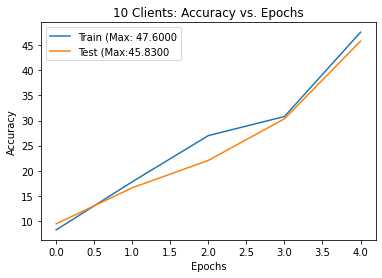

In [15]:
plt.plot(list(range(num_epochs)), total_train_acc, label=f'Train (Max: {max(total_train_acc):.4f}')
plt.plot(list(range(num_epochs)), total_test_acc, label=f'Test (Max:{max(total_test_acc):.4f}')
plt.title(f'{num_clients} Clients: Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.savefig(f'./Results/{num_clients} Clients Accuracy vs. Epochs.png', bbox_inches='tight')
plt.show()

Total Test Accuracy: 49.01


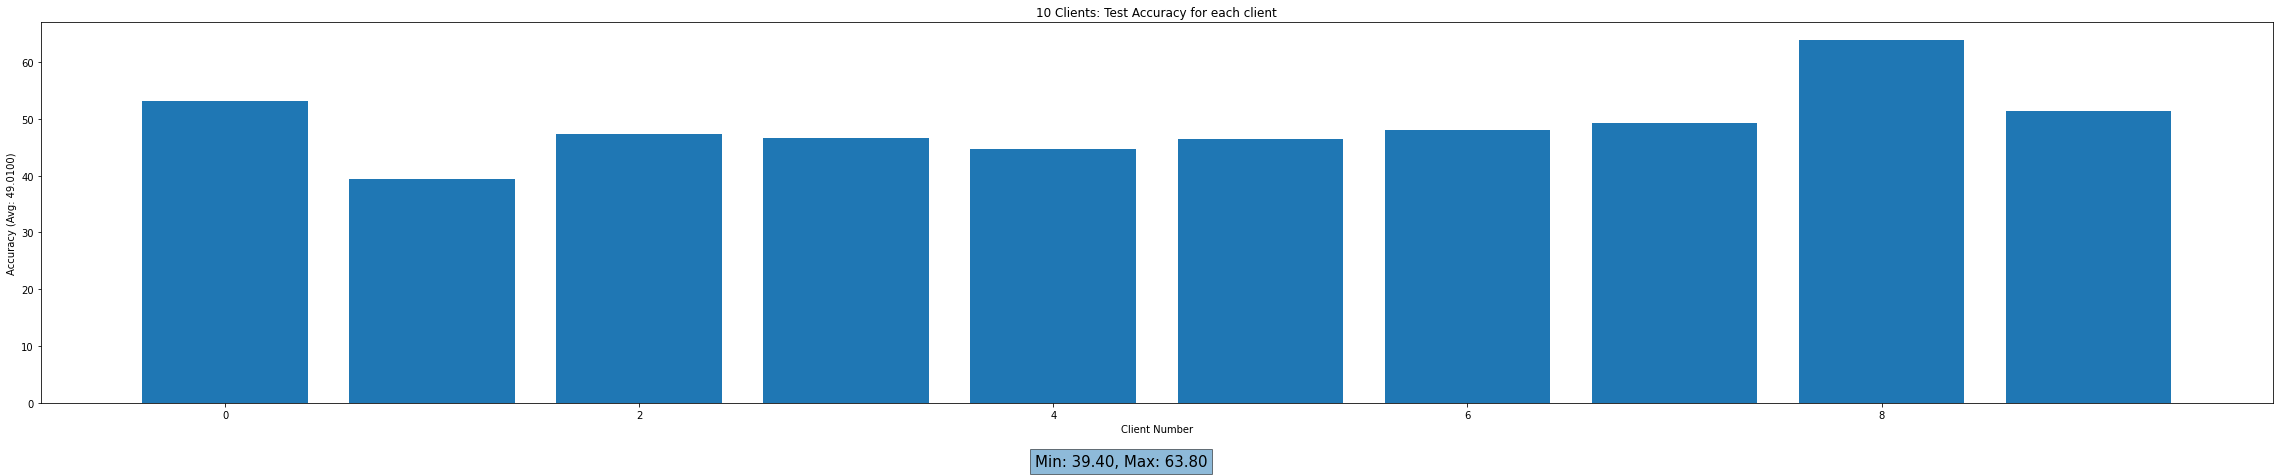

In [18]:
# test
# print("Test accuracy for each client:")
with torch.no_grad():
    n_correct = []
    n_samples = []
    test_acc = []
    for client in range(num_clients):
        images, labels = iter(test_loaders[client]).next()
        images = images.reshape(-1, 784).to(device)
        labels = labels.to(device)

        ## Forward
        # Forward through starting layers (with client 1)
        activations1 = startModels[client](images)
        remote_activations1 = activations1.detach().requires_grad_(True) 

        # Forward through middle layers (with server) 
        activations2 = serverModel(remote_activations1)
        remote_activations2 = activations2.detach().requires_grad_(True)

        # Forward through ending layers (with client 1)
        outputs = endModels[client](remote_activations2)

        # value, index
        _, predicted = torch.max(outputs.data, 1)
        n_correct.append((predicted == labels).sum().item())
        n_samples.append(labels.size(0))
        test_acc.append(100.0 * n_correct[-1]/n_samples[-1])
        # print(f"Client {client}: {test_acc[-1]:.4f}")
    print(f'Total Test Accuracy: {100*sum(n_correct)/sum(n_samples)}')
plt.figure(figsize=(40, 7))
plt.xlabel('Client Number')
plt.ylabel(f'Accuracy (Avg: {100*sum(n_correct)/sum(n_samples):.4f})')
plt.title(f'{num_clients} Clients: Test Accuracy for each client')
plt.bar(list(range(num_clients)),test_acc)
plt.figtext(0.5, 0, f"Min: {min(test_acc):.2f}, Max: {max(test_acc):.2f}", ha="center", fontsize=15, bbox={"alpha":0.5, "pad":5})
plt.savefig(f'./Results/{num_clients} Test Accuracy for each client.png', bbox_inches='tight')
plt.show()

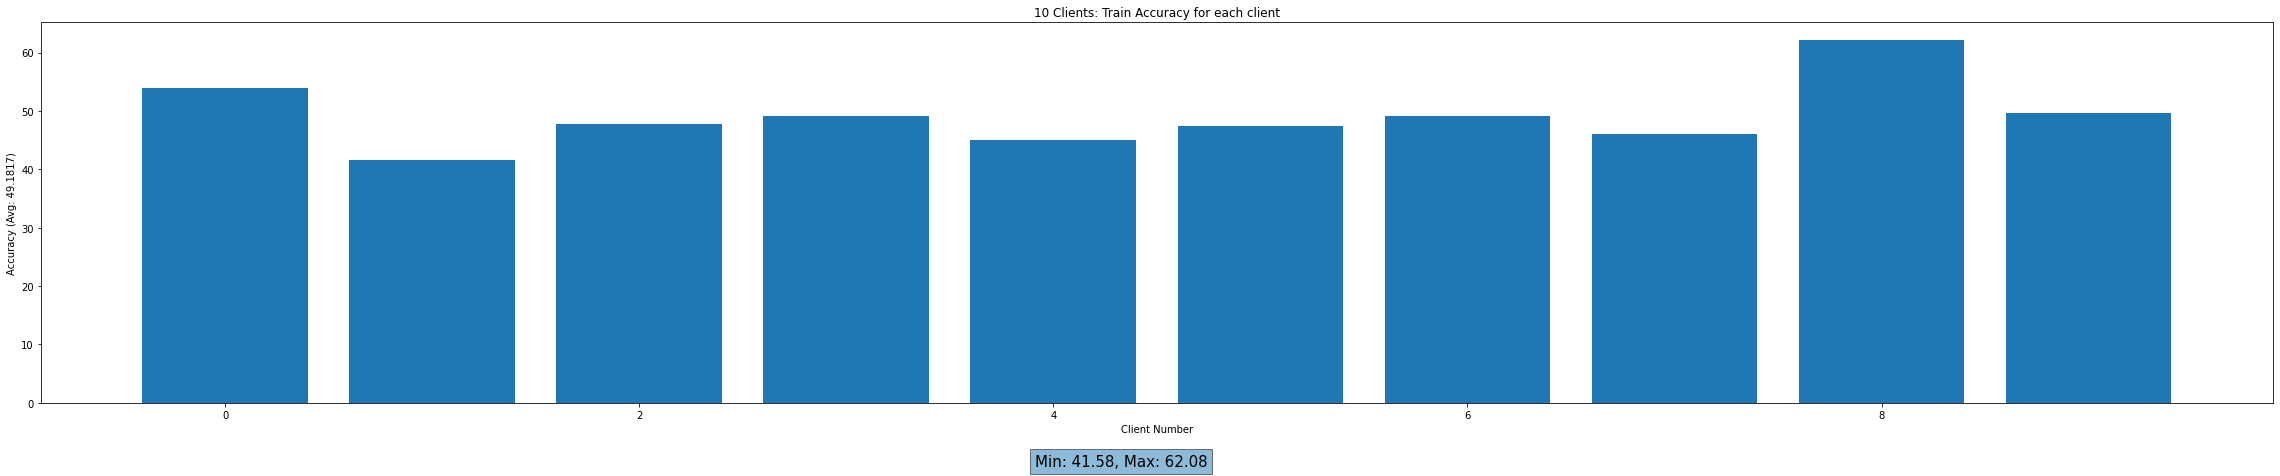

In [21]:
# train accuracy
# print("Train accuracy for each client")
with torch.no_grad():
    n_correct = []
    n_samples = []
    train_acc = []
    for client in range(num_clients):
        images, labels = iter(train_loaders[client]).next()
        images = images.reshape(-1, 784).to(device)
        labels = labels.to(device)

        ## Forward
        # Forward through starting layers (with client 1)
        activations1 = startModels[client](images)
        remote_activations1 = activations1.detach().requires_grad_(True) 

        # Forward through middle layers (with server) 
        activations2 = serverModel(remote_activations1)
        remote_activations2 = activations2.detach().requires_grad_(True)

        # Forward through ending layers (with client 1)
        outputs = endModels[client](remote_activations2)

        # value, index
        _, predicted = torch.max(outputs.data, 1)
        n_correct.append((predicted == labels).sum().item())
        n_samples.append(labels.size(0))
        train_acc.append(100.0 * n_correct[-1]/n_samples[-1])
        # print(f"Client {client}: {train_acc[-1]:.4f}")
    # print(f'Total Train Accuracy: {100*sum(n_correct)/sum(n_samples)}')
plt.figure(figsize=(40, 7))
plt.xlabel('Client Number')
plt.ylabel(f'Accuracy (Avg: {100*sum(n_correct)/sum(n_samples):.4f})')
plt.title(f'{num_clients} Clients: Train Accuracy for each client')
plt.bar(list(range(num_clients)),train_acc)
plt.figtext(0.5, 0, f"Min: {min(train_acc):.2f}, Max: {max(train_acc):.2f}", ha="center", fontsize=15, bbox={"alpha":0.5, "pad":5})
plt.savefig(f'./Results/{num_clients} Clients Train Accuracy for each client.png', bbox_inches='tight')
plt.show()